In [64]:
from data import get_orbit, random_config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchdiffeq import odeint
device = torch.device("cpu")

In [3]:
num_steps = 500
state = random_config(nu=2e-1, min_radius=0.9, max_radius=1.8)
orbit, settings = get_orbit(state, t_points=num_steps, t_span=[0,15], nbodies=3)
state = state[:,1:]
orbit = orbit[:,1:]

In [52]:
state_tensor = torch.Tensor(state).to(device)
orbit_tensor = torch.Tensor(orbit).to(device)
new_state = torch.cat((torch.flatten(state_tensor[:,:2]), torch.flatten(state_tensor[:,2:])))
new_orbit = torch.cat((torch.flatten(orbit_tensor[:,:2], start_dim = 0, end_dim = 1), torch.flatten(orbit_tensor[:,2:], start_dim = 0, end_dim = 1)), dim = 0)

tensor([[ 0.6709, -0.7914,  0.5092,  0.4211],
        [ 0.3500,  0.9767, -0.8044,  0.2540],
        [-1.0208, -0.1853,  0.1512, -0.7419]])
tensor([[[ 0.6709,  0.6860,  0.7009,  ...,  1.1561,  1.1514,  1.1464],
         [-0.7914, -0.7786, -0.7654,  ..., -0.0260, -0.0080,  0.0099],
         [ 0.5092,  0.4987,  0.4878,  ..., -0.1540, -0.1609, -0.1678],
         [ 0.4211,  0.4332,  0.4452,  ...,  0.5985,  0.5975,  0.5963]],

        [[ 0.3500,  0.3257,  0.3013,  ..., -1.6417, -1.6268, -1.6119],
         [ 0.9767,  0.9841,  0.9911,  ..., -1.0634, -1.0867, -1.1093],
         [-0.8044, -0.8097, -0.8147,  ...,  0.4930,  0.4954,  0.4973],
         [ 0.2540,  0.2388,  0.2234,  ..., -0.7870, -0.7638, -0.7415]],

        [[-1.0208, -1.0161, -1.0108,  ..., -1.6670, -1.6814, -1.6957],
         [-0.1853, -0.2075, -0.2297,  ...,  0.0913,  0.0946,  0.0973],
         [ 0.1512,  0.1670,  0.1828,  ..., -0.4831, -0.4786, -0.4737],
         [-0.7419, -0.7388, -0.7354,  ...,  0.1216,  0.0995,  0.0784]]])
tor

In [16]:
class NeuralODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 6,
            hidden_dim = 64,
            output_dim = 6,
            hidden_depth = 2
        )

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        state_reshaped = torch.flatten(state[:,:2], start_dim = -2)
        acceleration = self.odefunc(state_reshaped).view(3, 2)
        acceleration = acceleration - acceleration.mean(dim = -2, keepdim = True)
        return torch.cat((state[:,2:], acceleration), dim = -1)

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [263]:
class SymmetricNeuralODE(nn.Module):
    def __init__(self, hidden_dim, hidden_depth):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 6,
            hidden_dim = hidden_dim,
            output_dim = 2,
            hidden_depth = hidden_depth
        )
        self.input_weight = torch.Tensor([
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]

    ],
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ]
        ]).float()
        self.output_weight = torch.Tensor([
    [2, 2, -1, -1, -1, -1],
    [-1, -1, 2, 2, -1, -1],
    [-1, -1, -1, -1, 2, 2]
        ]).float()

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        return torch.cat((state[6:], (self.output_weight @ self.odefunc(self.input_weight @ state[:6])).view(-1)))
        

        
        

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [262]:
class mlp_helper(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_depth):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.hidden_depth = hidden_depth

        self.layers = nn.ParameterList([nn.Linear(input_dim, hidden_dim)])
        for i in range(hidden_depth - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

        def initial(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        for layer in self.layers:
            initial(layer)
    def forward(self, x):
        act = nn.ReLU()
        hidden = act(self.layers[0](x))
        saved = hidden
        for i in range(1, self.hidden_depth):
            hidden = act(self.layers[i](hidden))
            if i % 8 == 0:
                hidden = hidden + saved
                saved = hidden
        return self.layers[self.hidden_depth](hidden)
        
    

class SymmetricNeuralODE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = mlp_helper(
            input_dim = 6,
            hidden_dim = 16,
            output_dim = 2,
            hidden_depth = 16
        )
        self.input_weight = torch.Tensor([
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]

    ],
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ]
        ]).float()
        self.input_weight2 = torch.Tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
        ]).float()
        self.output_weight = torch.Tensor([
    [2, 2, -1, -1, -1, -1],
    [-1, -1, 2, 2, -1, -1],
    [-1, -1, -1, -1, 2, 2]
        ]).float()

    def forward(self, t, state):
        return torch.cat((state[6:], (self.output_weight @ self.odefunc(self.input_weight @ state[:6])).view(-1)))
        

        
        

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [ ]:
class SymmetricNeuralODE3(nn.Module):
    def __init__(self, hidden_dim, hidden_depth):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 6,
            hidden_dim = hidden_dim,
            output_dim = 6,
            hidden_depth = hidden_depth
        )
        self.input_weight = torch.Tensor([
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]

    ],
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ]
        ]).float()
        self.output_weight = torch.Tensor([
    [2, 2, -1, -1, -1, -1],
    [-1, -1, 2, 2, -1, -1],
    [-1, -1, -1, -1, 2, 2]
        ]).float()

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        return torch.cat((state[6:], (self.output_weight @ self.odefunc(self.input_weight @ state[:6])).view(-1)))
        

        
        

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [201]:
class SuperSymmetricNeuralODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 3,
            hidden_dim = 16,
            output_dim = 2,
            hidden_depth = 8
        )
        self.input_weight = torch.Tensor([
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]

    ],
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ]
        ]).float()
        self.input_weight2 = torch.Tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
        ]).float()
        self.output_weight = torch.Tensor([
    [2, 2, -1, -1, -1, -1],
    [-1, -1, 2, 2, -1, -1],
    [-1, -1, -1, -1, 2, 2]
        ]).float()

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        # perm11 = state[:6]
        # perm12 = perm11[[0, 1, 4, 5, 2, 3]]
        # acc1 = self.odefunc(perm11) + self.odefunc(perm12)

        # perm21 = perm11[[2, 3, 4, 5, 0, 1]]
        # perm22 = perm11[[2, 3, 0, 1, 4, 5]]
        # acc2 = self.odefunc(perm21) + self.odefunc(perm22)

        # perm31 = perm11[[4, 5, 0, 1, 2, 3]]
        # perm32 = perm11[[4, 5, 2, 3, 0, 1]]
        # acc3 = self.odefunc(perm31) + self.odefunc(perm32)

        # mean = (1/3)*(acc1 + acc2 + acc3)

        # acceleration = torch.cat((
        #     acc1 - mean,
        #     acc2 - mean,
        #     acc3 - mean
        #     ))
        # return torch.cat((state[6:], acceleration))
        return torch.cat((state[6:], (self.output_weight @ self.odefunc(self.input_weight @ state[:6])).view(-1)))
        

        
        

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [238]:
state_tensor = torch.Tensor(state).to(device)
orbit_tensor = torch.Tensor(orbit).to(device)
# model = SymmetricNeuralODE().to(device)
model.train()
decay = 1.0
obs_times = torch.linspace(0, 15, num_steps).to(device)
lr = 0.003
num_iter = 1000
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
for group in optimizer.param_groups:
        group["lr"] = lr
weights = 1.0**obs_times


for itr in range(num_iter):
    optimizer.zero_grad()
    trajectory = torch.permute(model.simulate(new_state, obs_times), (1, 0))
    loss = (
        (trajectory - new_orbit)
        .abs()
        .mul(weights)
        .mean()
    )
    if itr % 1 == 0:
        print(itr, loss.item())
    loss.backward()

    optimizer.step()

0 0.6378077268600464
1 0.6373531818389893
2 0.6372323632240295
3 0.6378042101860046


KeyboardInterrupt: 

In [264]:
state_tensor = torch.Tensor(state).to(device)
orbit_tensor = torch.Tensor(orbit).to(device)
model2 = SymmetricNeuralODE2().to(device)
torch.autograd.set_detect_anomaly(False)
model2.train()
decay = 1.0
obs_times = torch.linspace(0, 15, num_steps).to(device)
lr = 0.01
num_iter = 1000
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
for group in optimizer2.param_groups:
        group["lr"] = lr
weights = 1.0**obs_times
on_term = 1
off_term = .1
state_weights = torch.Tensor([
    [on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term],
    [off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term],
    [off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term]
    ]).float().view(3,12,1)
current_weight = state_weights[0]


for itr in range(num_iter):
    optimizer2.zero_grad()
    trajectory = torch.permute(model2.simulate(new_state, obs_times), (1, 0))
    loss = (
        (trajectory - new_orbit)
        .abs()
        .mul(weights)
        .mul(current_weight)
        .mean()
    )
    if itr % 1 == 0:
        print(itr, loss.item())
    if itr % 10 == 0:
        i = np.random.randint(3)
        current_weight = state_weights[i]
        print("Body:", i)
    loss.backward()

    optimizer2.step()

0 2.9020097255706787
Body: 1
1 0.4136315882205963
2 0.3167489767074585
3 0.3459787964820862
4 0.4063883423805237
5 0.3832593262195587
6 0.32524925470352173
7 0.3533304035663605
8 0.25746241211891174
9 0.32121533155441284
10 0.335264652967453
Body: 0
11 0.5442805290222168
12 0.37648865580558777
13 0.33984869718551636


KeyboardInterrupt: 

In [ ]:
state_tensor = torch.Tensor(state).to(device)
orbit_tensor = torch.Tensor(orbit).to(device)
model3 = SymmetricNeuralODE2().to(device)
torch.autograd.set_detect_anomaly(False)
model3.train()
decay = 1.0
obs_times = torch.linspace(0, 15, num_steps).to(device)
lr = 0.01
num_iter = 1000
optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr)
for group in optimizer3.param_groups:
        group["lr"] = lr
weights = 1.0**obs_times
on_term = 1
off_term = .1
state_weights = torch.Tensor([
    [on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term],
    [off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term],
    [off_term, off_term, off_term, off_term, on_term, on_term, off_term, off_term, off_term, off_term, on_term, on_term]
    ]).float().view(3,12,1)
current_weight = state_weights[0]


for itr in range(num_iter):
    optimizer3.zero_grad()
    trajectory = torch.permute(model3.simulate(new_state, obs_times), (1, 0))
    loss = (
        (trajectory - new_orbit)
        .abs()
        .mul(weights)
        .mul(current_weight)
        .mean()
    )
    if itr % 1 == 0:
        print(itr, loss.item())
    if itr % 10 == 0:
        i = np.random.randint(3)
        current_weight = state_weights[i]
        print("Body:", i)
    loss.backward()

    optimizer3.step()

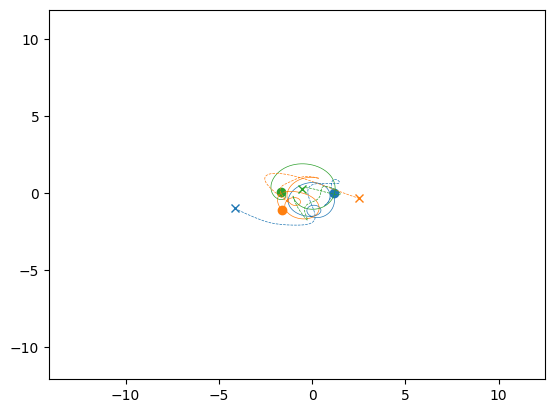

In [265]:
# B, S, T
#positions = orbit.transpose(2,0,1)[:,:,:2]
#predictions = trajectory.detach().cpu().numpy().transpose(2,0,1)[:,:,:2]

positions = new_orbit[:6].T.view(num_steps, 3, 2).detach().cpu().numpy()
predictions = trajectory[:6].T.view(num_steps, 3, 2).detach().cpu().numpy()

file_name = "symmetric_fixed_orbit"
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), predictions[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), predictions[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(predictions[i, j, 0], predictions[i, j, 1])
        trajectories_approx[j].set_data(predictions[:i, j, 0], predictions[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=range(0, num_steps, 2), init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=50)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()